This script generates a zone plate pattern (based on partial filling) given the material, energy, grid size and number of zones as input

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import urllib
import pickle
from tqdm import tqdm, trange

Importing all the required libraries. Numba is used to optimize functions.

In [2]:
def repeat_pattern(X,Y,Z):
    flag_ = np.where((X>0)&(Y>0))
    flag1 = np.where((X>0)&(Y<0))
    flag1 = tuple((flag1[0][::-1],flag1[1]))
    Z[flag1] = Z[flag_]
    flag2 = np.where((X<0)&(Y>0))
    flag2 = tuple((flag2[0],flag2[1][::-1]))
    Z[flag2] = Z[flag_]
    flag3 = np.where((X<0)&(Y<0))
    flag3 = tuple((flag3[0][::-1],flag3[1][::-1]))
    Z[flag3] = Z[flag_]
    return Z


*repeat_pattern* : produces the zone plate pattern given the pattern in only one quadrant(X,Y>0) as input.
* *Inputs* : X and Y grid denoting the coordinates and Z containing the pattern in one quadrant.
* *Outputs* : Z itself is modified to reflect the repition.

In [3]:
def get_property(mat,energy):
    url = "http://henke.lbl.gov/cgi-bin/pert_cgi.pl"
    data = {'Element':str(mat), 'Energy':str(energy), 'submit':'Submit Query'}
    data = urllib.parse.urlencode(data)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    resp = urllib.request.urlopen(req)
    respDat = resp.read()
    response = respDat.split()
    d =  b'g/cm^3<li>Delta'
    i = response.index(d)
    delta = str(response[i+2])[:str(response[i+2]).index('<li>Beta')][2:]
    beta = str(response[i+4])[2:-1]
    return float(delta),float(beta)


*get_property* : gets delta and beta for a given material at the specified energy from Henke et al.
* *Inputs* : mat - material, energy - energy in eV
* *Outputs* : delta, beta

In [4]:
@njit   # equivalent to "jit(nopython=True)".
def partial_fill(x,y,step,r1,r2,n):
    x_ = np.linspace(x-step/2,x+step/2,n)
    y_ = np.linspace(y-step/2,y+step/2,n)
    cnts = 0
    for i in range(n):
        for j in range(n):
            z = (x_[i] * x_[i] + y_[j] * y_[j])
            if r1*r1 < z < r2*r2:
                cnts += 1
    fill_factor = cnts/(n*n)
    return fill_factor

*partial_fill* : workhorse function for determining the fill pattern. This function is thus used in a loop. njit is used to optimize the function.
* *Inputs* : x,y - coordinates of the point, step - step size, r1,r2 - inner and outer radii of ring, n - resolution
* *Outputs* : fill_factor - value of the pixel based on amount of ring passing through it    

In [5]:
#find the radius of the nth zone
def zone_radius(n,f,wavel):
    return np.sqrt(n*wavel*f + ((n*wavel)/2)**2)

*zone_radius* : functon to find the radius of a zone given the zone number and wavelength
* *Inputs* : n - zone number, f - focal length, wavel - wavelength
* *Outputs* : radius of the zone as specified by the inputs

In [6]:
def make_quadrant(X,Y,flag,r1,r2,step,n,zone_number):
    z = np.zeros(np.shape(X))
    Z = np.sqrt(X**2+Y**2)
    for l in range(len(flag[0])):
        i = flag[0][l]
        j = flag[1][l]
        if 0.75*r1< Z[i][j] < 1.25*r2:
            x1 = X[i][j]
            y1 = Y[i][j]
            z[i][j] = partial_fill(x1,y1,step,r1,r2,n)
    z[tuple((flag[1],flag[0]))] = z[tuple((flag[0],flag[1]))]
    return z

*make_quadrant* : function used to create a quadrant of a ring given the inner and outer radius and zone number
* *Inputs* : X,Y - grid, flag - specifies the quadrant to be filled (i.e. where X,Y>0), r1,r2 - inner and outer radii, n - parameter for the partial_fill function  
* *Outputs* : z - output pattern with one quadrant filled.

In [7]:
mat = 'Au'
energy = 5000                   #Energy in EV
f = 6*10**(-3)          #focal length in meters 
wavel = (1239.84/energy)*10**(-9)  #Wavelength in meters
delta,beta = get_property(mat,energy)

grid_size = 5000
n = 250
zp = np.zeros((grid_size,grid_size))
x =  np.linspace(-50e-6,50e-6,grid_size)
step_xy = x[-1]-x[-2]
X,Y = np.meshgrid(x,x)
flag = np.where((X>0)&(Y>0)&(X>=Y))
zones = 100 #number of zones
radius = np.zeros(zones)

Setting up the parameters and initializing the variables.

In [8]:
for k in range(zones):
    radius[k] = zone_radius(k,f,wavel)

Filling the radius array with the radius of zones for later use in making the rings.

In [9]:
#2D ZP
for i in tqdm(range(zones),desc='making zones ... '):
    if i%2 == 1 :
        r1 = radius[i-1]
        r2 = radius[i]
        ring = make_quadrant(X,Y,flag,r1,r2,step_xy,500,zone_number = i)
        zp+=ring
zp = repeat_pattern(X,Y,zp)

making zones ... : 100%|██████████| 100/100 [09:55<00:00,  5.95s/it]


Loop to generate the zone plate and repeat the pattern to cover all the four quadrants.

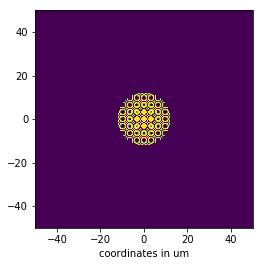

In [10]:
zp_coords =(-50,50,-50,50)
fig, ax1 = plt.subplots(1,1)
ax1.imshow(zp,extent=zp_coords)
ax1.set_xlabel('coordinates in um')
plt.show()

In [11]:
params = {'step_xy':step_xy,'energy(in eV)':energy,'wavelength in m':wavel,'focal_length':f,'zp_coords':zp_coords,'delta':delta,'beta':beta}
pickle.dump(params,open('parameters.pickle','wb'))
np.save('zp.npy',zp)

*saving the parameters and the zone plate array*